In [1]:
import pandas as pd
from  sklearn import decomposition

def load_data(file : str) -> pd.DataFrame:   
  """
  Load the dataset
  """
  na_val = ["n/a", "na", "?", "NaN"]
  df = pd.read_csv(file, na_values = na_val)
  return df

def replace_na_values(df : pd.DataFrame) -> pd.DataFrame:
  """
  Return the data with the na values filled by the mean of the column
  """
  n = len(df.columns)
  for i in range(n):
    index = 0
    while type(df[df.columns[i]][index]) == float:
        index+=1
    if type(df[df.columns[i]][index])!= str:# and df[df.columns[i]].dtype != object:
        df[df.columns[i]]=df[df.columns[i]].fillna(df[df.columns[i]].mean())   
    else:
        df[df.columns[i]]=df[df.columns[i]].fillna(df[df.columns[i]].mode()[0])

  df = df.applymap(lambda x: x.replace("\t", "") if type(x) == str else x)
  df = df.applymap(lambda x: x.replace(" ", "") if type(x) == str else x)
 
  return df

def categoric_to_one_hot(df: pd.DataFrame) -> pd.DataFrame: 
  """
  Transform categorical data to one hot encoded vectors
  """
  a=0
  if df[df.columns[-1]].dtype!=int:
    a=1
  n = len(df.columns)
  cols = [] #Categorical columns we will drop at the end
  for i in range(n):
    #print(df[df.columns[i]].dtype)
    if df[df.columns[i]].dtype == str or df[df.columns[i]].dtype == object:
      cols.append(i)
      df[df.columns[i]] = pd.Categorical(df[df.columns[i]])
      #One hot encoded version of the categorical column#
      new_cols = pd.get_dummies(df[df.columns[i]], prefix = list(df.columns)[i] )
      df = pd.concat([df, new_cols] , axis=1, sort=False)
  df.drop(df.columns[cols], axis=1, inplace=True)
  if a==1:
    df=df.drop(df.columns[-1],axis=1)
 
  return df



def preprocess_data(file : str) -> pd.DataFrame: 
  """
  Preprocess the data
  """
  df = load_data(file) 
  df = replace_na_values(df)
  
  
  return df

In [2]:
import numpy as np

def apply_pca(df: pd.DataFrame) -> pd.DataFrame: 
  """
  Reduce dimensions thanks to pca
  """
  pca = decomposition.PCA()
  df=pca.fit_transform(df)
  # Selecting only the best components
  max_variance = np.max(pca.explained_variance_ratio_)

  pc_number = len([v for v in pca.explained_variance_ratio_ if v >= max_variance/10000])
  df = df[:, :pc_number]
  return pd.DataFrame(df)
  


def create_datasets(db):    
    data=preprocess_data(db)
    y= data[data.columns[-1]]
    for i in range(len(y)):
      if y[i]>=5:
        y[i]=0
      else:
        y[i]=1
   
    X=data.drop(data.columns[-1],axis=1)
    #X=apply_pca(X)
    X=pd.DataFrame(X)
    return X, y

In [3]:
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold

def create_tree(db, criterion, splitter):  
   
   """
   db is the database file path
   criterion is the criterion used in the decision tree
   splitter is the splitter used in the decision tree
   """

   X, y = create_datasets(db)
  
   max = 0
   NUM_SPLITS = 5
   clf = tree.DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=5)
   # split the data
   kf = KFold(n_splits=NUM_SPLITS, shuffle=True)
   # Train, test and compute the metrics on each split
   
   for train_index, test_index in kf.split(X):
      
      X_train = X.iloc[train_index,:]
      y_train = y[train_index]
      X_test = X.iloc[test_index,:]
      y_test = y[test_index]
      clf.fit(X_train, y_train)
      # Predictions on the test set
      predictions = clf.predict(X_test)
      # we should chose the best train and test set
      if max < metrics.accuracy_score(y_test, predictions):
         max = metrics.accuracy_score(y_test, predictions)
         X_train_f = X.iloc[train_index,:]
         y_train_f = y[train_index]
         X_test_f = X.iloc[test_index,:]
         y_test_f = y[test_index]
          
   predictions = clf.predict(X_test_f)
   clf.fit(X_train_f, y_train_f)
   recall = metrics.recall_score(y_test_f, predictions)
   precision=metrics.precision_score(y_test_f, predictions)
   print('precision= {}, recall= {}'.format(precision, recall))

   return clf, precision, recall

In [4]:
from sklearn.linear_model import LogisticRegression

def create_logistic_regression(db):
   X, y = create_datasets(db)

   clf = LogisticRegression(random_state=0)
  # split the data
   NUM_SPLITS = 5
   kf = KFold(n_splits=NUM_SPLITS, shuffle=True)
   # Train, test and compute the metrics on each split
   max=0
   for train_index, test_index in kf.split(X):
      
      X_train = X.iloc[train_index,:]
      y_train = y[train_index]
      X_test = X.iloc[test_index,:]
      y_test = y[test_index]
      clf.fit(X_train, y_train)
      # Predictions on the test set
      predictions = clf.predict(X_test)
      if max < metrics.accuracy_score(y_test, predictions):
         max = metrics.accuracy_score(y_test, predictions)
         X_train_f = X.iloc[train_index,:]
         y_train_f = y[train_index]
         X_test_f = X.iloc[test_index,:]
         y_test_f = y[test_index]
          
   predictions = clf.predict(X_test_f)
   clf.fit(X_train_f, y_train_f)
   recall = metrics.recall_score(y_test_f, predictions)
   precision=metrics.precision_score(y_test_f, predictions)
   print('precision= {}, recall= {}'.format(precision, recall))
   

In [5]:
import graphviz
def main(db):        
  """
  db is the the file path
  """
  clf,precision,recall=create_tree(db, 'gini', 'random')
  dot_data = tree.export_graphviz(clf,filled=True)
  graph = graphviz.Source(dot_data)
  graph.render('cancer')
  tree.plot_tree(clf)
  
  

In [6]:
create_logistic_regression('/content/drive/MyDrive/SPYGLASS/data/annotations/medical_data  - medical_data  - medical_data  - medical_data .csv')

precision= 0.7857142857142857, recall= 1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


precision= 1.0, recall= 0.8571428571428571


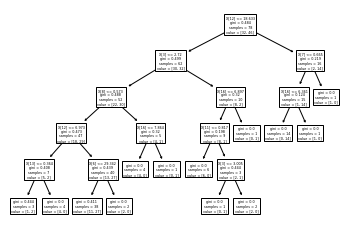

In [8]:

main('/content/drive/MyDrive/SPYGLASS/data/annotations/medical_data  - medical_data  - medical_data  - medical_data .csv')